In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
APR_DIR = "phase2_apr2/"
DATA_DIR ="new_tags_data/"

In [2]:
import numpy as np
import os
def seed_torch(seed=12345):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch()

In [3]:
from collections import OrderedDict
LIM =None
def corpus_reader(path, delim='\t', word_idx=0, fname_idx=1, label_idx=-1):
  tokens, file_names, labels = [], [], []
  tmp_tok, tmp_fname, tmp_lab = [], [], []
  label_set = []
  with open(path, 'r') as reader:
    for line in reader:
      line = line.strip()
      cols = line.split(delim)
      #print(len(cols))
      if len(cols) < 2:
        if len(tmp_tok) > 0:
            tokens.append(tmp_tok); file_names.append(tmp_fname); labels.append(tmp_lab)
        tmp_tok = [] 
        tmp_fname = []
        tmp_lab = []
        continue
      else:
        tmp_tok.append(cols[word_idx])
        tmp_fname.append(cols[fname_idx])
        tmp_lab.append(cols[label_idx])
        label_set.append(cols[label_idx])
  return tokens[:LIM], file_names[:LIM], labels[:LIM], list(OrderedDict.fromkeys(label_set))

_, fnames, _, label_set = corpus_reader(DATA_DIR +'train_SL200.txt', delim='\t')
label_set.append('X')
#tag2idx = {'B-location': 0, 'O': 1, 'I-location': 2, 'X': 3}
tag2idx = {t: i for i, t in enumerate(label_set)}
#tag2idx = {'B-location': 0, 'O': 1, 'I-location': 2, 'X': 3}

print(tag2idx)
unique_labels = list(label_set)
print(len(tag2idx))

{'B-location': 0, 'O': 1, 'I-location': 2, 'B-date': 3, 'B-person_name': 4, 'I-person_name': 5, 'B-id': 6, 'B-age': 7, 'B-hospital_name': 8, 'I-hospital_name': 9, 'B-room_no': 10, 'I-id': 11, 'I-age': 12, 'I-date': 13, 'B-telephone_no': 14, 'I-telephone_no': 15, 'B-org_name': 16, 'I-org_name': 17, 'I-room_no': 18, 'B-web_url': 19, 'I-web_url': 20, 'X': 21}
22


In [4]:
import pickle 
with open(APR_DIR + 'tag2idx.pkl', 'wb') as f:
    pickle.dump(tag2idx, f, pickle.HIGHEST_PROTOCOL)

with open(APR_DIR + 'unique_labels.pkl', 'wb') as f:
    pickle.dump(unique_labels, f, pickle.HIGHEST_PROTOCOL)

In [5]:
# {'B-location': 0, 'O': 1, 'I-location': 2, 'B-date': 3, 'B-person_name': 4, 'I-person_name': 5, 'B-id': 6, 'B-age': 7, 'B-hospital_name': 8, 'I-hospital_name': 9, 'B-room_no': 10, 'I-id': 11, 'I-age': 12, 'I-date': 13, 'B-telephone_no': 14, 'I-telephone_no': 15, 'B-org_name': 16, 'I-org_name': 17, 'I-room_no': 18, 'B-web_url': 19, 'I-web_url': 20, 'X': 21}
# # 22

In [6]:
fnames[0]

['287305_2781269_20180805150026.624',
 '287305_2781269_20180805150026.624',
 '287305_2781269_20180805150026.624',
 '287305_2781269_20180805150026.624',
 '287305_2781269_20180805150026.624']

In [7]:
from torch.utils import data 
from transformers import BertTokenizer

class NER_Dataset(data.Dataset):
    def __init__(self, sentences, fnames, labels, tokenizer_path = '', use_bert_emb=True):
       self.sentences = sentences
       self.fnames = fnames
       self.labels = labels
       self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path, do_lower_case=True)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = []
        for x in self.labels[idx]:
            if x in tag2idx.keys():
                label.append(tag2idx[x])
            else:
                label.append(tag2idx['O'])
        bert_tokens = []
        orig_to_tok_map = []
        bert_tokens.append('[CLS]')
        modified_labels = [tag2idx['X']]
        for i, token in enumerate(sentence):
          if len(bert_tokens) >= 512:
            break
          orig_to_tok_map.append(len(bert_tokens))
          modified_labels.append(label[i])
          new_token = self.tokenizer.tokenize(token)
          bert_tokens.extend(new_token)
          modified_labels.extend([tag2idx['X']] * (len(new_token) -1))
          
        bert_tokens.append('[SEP]')
        modified_labels.append(tag2idx['X'])
        token_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)
        f_name = self.fnames[idx][0]
        if len(token_ids) > 511:
            token_ids = token_ids[:512]
            modified_labels = modified_labels[:512]
            #f_name = f_name[:512]
        # tokens_ids, lenth of tokens(use for dynamic padding), orig_to_tok_map(will used for prediction) labels, original_token
        f_names = [f_name] * len(token_ids)
        return token_ids, len(token_ids), orig_to_tok_map, modified_labels, sentence, f_names
 
def pad(batch):
    '''Pads to the longest sample'''
    get_element = lambda x: [sample[x] for sample in batch]
    seq_len = get_element(1)
    maxlen = np.array(seq_len).max()
    do_pad = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    tok_ids = do_pad(0, maxlen)
    attn_mask = [[(i>0) for i in ids] for ids in tok_ids] 
    LT = torch.LongTensor
    label = do_pad(-3, maxlen)
    
    token_ids = get_element(0)
    token_ids_len = torch.LongTensor(list(map(len, token_ids)))
    _, sorted_idx = token_ids_len.sort(0, descending=True)
    
    #sorting based on padding size
    tok_ids = LT(tok_ids)[sorted_idx]
    attn_mask = LT(attn_mask)[sorted_idx]
    label = LT(label)[sorted_idx]
    
    #orig_to_tok_map = LT(get_element(2))[sorted_idx]
    
    unsorted_orig_tok_map = get_element(2)
    unsorted_sent = get_element(-2)
    unsorted_f_names = get_element(-1)
    
    sorted_sent = []
    sorted_f_names = []
    sorted_org_tok_map = []
    for i in sorted_idx.cpu().numpy():
        sorted_sent.append(unsorted_sent[i])
        sorted_f_names.append(unsorted_f_names[i])
        sorted_org_tok_map.append(unsorted_orig_tok_map[i])
    return tok_ids, attn_mask, sorted_org_tok_map, label, sorted_sent, sorted_f_names

I1212 10:59:03.279425 140235405039360 file_utils.py:39] PyTorch version 1.1.0 available.
I1212 10:59:03.608171 140235405039360 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [8]:
from transformers import BertPreTrainedModel, BertModel
from torchcrf import CRF
#from torch.nn import log_softmax
log_soft = F.log_softmax

class Bert_CRF(BertPreTrainedModel):
    def __init__(self, config):
        super(Bert_CRF, self).__init__(config)
        self.num_labels = config.num_labels
        print(self.num_labels)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()
        
        self.crf = CRF(self.num_labels, batch_first=True)    
    
    def forward(self, input_ids, attn_masks, labels=None):  # dont confuse this with _forward_alg above.
        outputs = self.bert(input_ids, attn_masks)
        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        emission = self.classifier(sequence_output)
        
        #emission = self.classifier(lstm_out)
        attn_masks = attn_masks.type(torch.uint8)
        #labels = labels.type(torch.uint8)
        if labels is not None:
            loss = -self.crf(log_soft(emission, 2), labels, mask=attn_masks, reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emission, mask=attn_masks)
            return prediction
        #return scores, tag_seqs

In [9]:
#tokens, file_names, labels, label_set
train_sentences, file_names, train_labels, _ = corpus_reader(DATA_DIR + 'train_SL200.txt', delim='\t')
train_dataset = NER_Dataset(train_sentences, file_names, train_labels, tokenizer_path = '/home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps')
#eval_dataset = STSDataset(id_2_example, test_ids, Param)

dev_sentences, dev_file_names, dev_labels, _ = corpus_reader(DATA_DIR + 'test.txt', delim='\t')
dev_dataset = NER_Dataset(dev_sentences, dev_file_names, dev_labels, tokenizer_path = '/home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps')

I1212 10:59:09.595587 140235405039360 tokenization_utils.py:306] Model name '/home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps' is a path or url to a directory containing tokenizer files.
I1212 10:59:09.596513 140235405039360 tokenization_utils.py:335] Didn't find file /home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps/added_tokens.json. We won't load it

In [10]:
len(train_sentences)
#386750

386750

In [11]:
train_iter = data.DataLoader(dataset=train_dataset,
                            batch_size=16,
                            shuffle=True,
                            num_workers=4,
                            collate_fn=pad)
eval_iter = data.DataLoader(dataset=dev_dataset,
                            batch_size=16,
                            shuffle=False,
                            num_workers=1,
                            collate_fn=pad)


In [12]:
import timeit
import subprocess
from transformers import BertModel 
from tqdm import tqdm, trange
from transformers import AdamW, WarmupLinearSchedule

print('#Tags: ', len(tag2idx))
model = Bert_CRF.from_pretrained("/home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps", num_labels = len(tag2idx))
#print(model.parameters())
if torch.cuda.is_available():
  model.cuda()

num_epoch = 16
gradient_acc_steps = 1
t_total = len(train_iter) // gradient_acc_steps * num_epoch
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0, t_total=t_total)

I1212 10:59:11.747467 140235405039360 configuration_utils.py:148] loading configuration file /home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps/config.json
I1212 10:59:11.748398 140235405039360 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 22,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1212 10:59:11.749823 140235405039360 modeling_utils.py:334] loading weights file /home/ubuntu/dhana/EzBert/bert/our_pretrained_uncase/model_with_SL_128_9KSteps/pytorch_model.bin


#Tags:  22
22


I1212 10:59:15.532253 140235405039360 modeling_utils.py:405] Weights of Bert_CRF not initialized from pretrained model: ['classifier.weight', 'classifier.bias', 'crf.start_transitions', 'crf.end_transitions', 'crf.transitions']
I1212 10:59:15.533070 140235405039360 modeling_utils.py:408] Weights from pretrained model not used in Bert_CRF: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']


In [13]:
import datetime
from sklearn.metrics import classification_report

global_step = 0
#tr_loss, logging_loss = 0.0
model.zero_grad()
model.train()
training_loss = []
validation_loss = []
pearson_score = []
train_iterator = trange(num_epoch, desc="Epoch", disable=0)
best_f1 = 0.0
tmp_loss = 0.0
MAX_SCORE = 0.0 
MAX_EPOCH = 0

Epoch:   0%|          | 0/16 [00:00<?, ?it/s]

In [14]:

start_time = timeit.default_timer()

for epoch in (train_iterator):
    epoch_iterator = tqdm(train_iter, desc="Iteration", disable=-1)
    tr_loss = 0.0
    model.train()
    for step, batch in enumerate(epoch_iterator):
        s = timeit.default_timer()
        token_ids, attn_mask, orig_2_map, labels, original_tok, _= batch
        #print(labels)
        inputs = {'input_ids' : token_ids.to(device),
                 'attn_masks' : attn_mask.to(device),
                 'labels' : labels.to(device)
                 }  
        loss= model(**inputs) 
        loss.backward()
        tmp_loss += loss.item()
        tr_loss += loss.item()
        if (step + 1) % 1 == 0:
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            global_step += 1
        if step == 0:
            print('%s Step: %d of %d Loss: %f' %(str(datetime.datetime.now()), (step+1), len(epoch_iterator), tmp_loss))
        if (step+1) % 1000 == 0:
            print('%s Step: %d of %d Loss: %f' %(str(datetime.datetime.now()), (step+1), len(epoch_iterator), tmp_loss/1000))
            tmp_loss = 0.0
  
    print("Training Loss: %f for epoch %d" %(tr_loss/len(train_iter), epoch))
    training_loss.append(tr_loss/len(train_iter))
    #'''
    Y_pred = []
    Y_true = []
    val_loss = 0.0
    model.eval()
    writer = open(APR_DIR + 'prediction_'+str(epoch)+'.csv', 'w')
    for i, batch in enumerate(eval_iter):
        fname = dev_file_names[i][0]
        token_ids, attn_mask, orig_2_map, labels, original_token, filenames = batch
        #attn_mask.dt
        inputs = {'input_ids': token_ids.to(device),
                  'attn_masks' : attn_mask.to(device)
                 }  
        
        dev_inputs = {'input_ids' : token_ids.to(device),
                     'attn_masks' : attn_mask.to(device),
                     'labels' : labels.to(device)
                     } 
        with torch.torch.no_grad():
            tag_seqs = model(**inputs)
            tmp_eval_loss = model(**dev_inputs)
        val_loss += tmp_eval_loss.item()
        #print(labels.numpy())
        y_true = list(labels.cpu().numpy())
        for i, o2m in enumerate(orig_2_map):
            for j, orig_tok_idx in enumerate(o2m):
                writer.write(original_token[i][j] + '\t')
                writer.write(filenames[i][j] + '\t')
                #writer.write(str(scores[i][j]) + '\t')
                writer.write('NA\t')
                writer.write(unique_labels[y_true[i][orig_tok_idx]] + '\t')
                pred_tag = unique_labels[tag_seqs[i][orig_tok_idx]]
                if pred_tag == 'X':
                    pred_tag = 'O'
                writer.write(pred_tag + '\n')
                Y_true.append(unique_labels[y_true[i][orig_tok_idx]])
                Y_pred.append(pred_tag)
            writer.write('\n')
            
    validation_loss.append(val_loss/len(eval_iter))
    writer.flush()
    print('Epoch: ', epoch)
    #print(classification_report(y_pred=Y_pred, y_true=Y_true))
    command = "python conlleval.py < " + APR_DIR + "prediction_"+str(epoch)+".csv"
    process = subprocess.Popen(command,stdout=subprocess.PIPE, shell=True)
    result = process.communicate()[0].decode("utf-8")
    print(result)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': tr_loss/len(train_iter),
    }, APR_DIR + 'model_' + str(epoch) + '.pt')

total_time = timeit.default_timer() - start_time
print('Total training time: ',   total_time)

2019-12-12 10:59:20.091209 Step: 1 of 24172 Loss: 34.825382
2019-12-12 11:01:54.935637 Step: 1000 of 24172 Loss: 1.188062
2019-12-12 11:04:32.597347 Step: 2000 of 24172 Loss: 0.479009
2019-12-12 11:07:07.274856 Step: 3000 of 24172 Loss: 0.447093
2019-12-12 11:09:41.929404 Step: 4000 of 24172 Loss: 0.354401
2019-12-12 11:12:17.706725 Step: 5000 of 24172 Loss: 0.397724
2019-12-12 11:14:56.801268 Step: 6000 of 24172 Loss: 0.431707
2019-12-12 11:17:28.521043 Step: 7000 of 24172 Loss: 0.284069
2019-12-12 11:20:05.555144 Step: 8000 of 24172 Loss: 0.345935
2019-12-12 11:22:40.061125 Step: 9000 of 24172 Loss: 0.263037
2019-12-12 11:25:14.697096 Step: 10000 of 24172 Loss: 0.307490
2019-12-12 11:27:50.023089 Step: 11000 of 24172 Loss: 0.285687
2019-12-12 11:30:22.351705 Step: 12000 of 24172 Loss: 0.259938
2019-12-12 11:32:56.236215 Step: 13000 of 24172 Loss: 0.238009
2019-12-12 11:35:29.513624 Step: 14000 of 24172 Loss: 0.268181
2019-12-12 11:38:08.653153 Step: 15000 of 24172 Loss: 0.240225
2019

Epoch:   6%|▋         | 1/16 [1:09:15<17:18:50, 4155.35s/it]

2019-12-12 12:08:35.403011 Step: 1 of 24172 Loss: 32.534004
2019-12-12 12:11:09.041302 Step: 1000 of 24172 Loss: 0.219208
2019-12-12 12:13:44.349842 Step: 2000 of 24172 Loss: 0.173935
2019-12-12 12:16:17.768243 Step: 3000 of 24172 Loss: 0.205215
2019-12-12 12:18:56.248459 Step: 4000 of 24172 Loss: 0.185801
2019-12-12 12:21:31.193181 Step: 5000 of 24172 Loss: 0.211409
2019-12-12 12:24:04.981140 Step: 6000 of 24172 Loss: 0.192493
2019-12-12 12:26:38.440879 Step: 7000 of 24172 Loss: 0.206257
2019-12-12 12:29:10.706288 Step: 8000 of 24172 Loss: 0.187813
2019-12-12 12:31:44.421917 Step: 9000 of 24172 Loss: 0.173200
2019-12-12 12:34:18.710279 Step: 10000 of 24172 Loss: 0.163917
2019-12-12 12:36:51.717697 Step: 11000 of 24172 Loss: 0.183554
2019-12-12 12:39:27.813054 Step: 12000 of 24172 Loss: 0.217657
2019-12-12 12:42:04.576091 Step: 13000 of 24172 Loss: 0.178926
2019-12-12 12:44:41.032077 Step: 14000 of 24172 Loss: 0.196423
2019-12-12 12:47:18.637624 Step: 15000 of 24172 Loss: 0.188237
2019

Epoch:  12%|█▎        | 2/16 [2:18:27<16:09:21, 4154.43s/it]

2019-12-12 13:17:47.700507 Step: 1 of 24172 Loss: 32.253393
2019-12-12 13:20:20.333713 Step: 1000 of 24172 Loss: 0.180307
2019-12-12 13:22:53.785101 Step: 2000 of 24172 Loss: 0.182796
2019-12-12 13:25:28.450626 Step: 3000 of 24172 Loss: 0.158083
2019-12-12 13:28:02.261470 Step: 4000 of 24172 Loss: 0.177619
2019-12-12 13:30:37.120715 Step: 5000 of 24172 Loss: 0.141168
2019-12-12 13:33:14.320097 Step: 6000 of 24172 Loss: 0.199302
2019-12-12 13:35:51.343998 Step: 7000 of 24172 Loss: 0.141470
2019-12-12 13:38:25.406830 Step: 8000 of 24172 Loss: 0.168327
2019-12-12 13:41:01.657518 Step: 9000 of 24172 Loss: 0.215091
2019-12-12 13:43:33.736927 Step: 10000 of 24172 Loss: 0.144494
2019-12-12 13:46:09.083549 Step: 11000 of 24172 Loss: 0.144449
2019-12-12 13:48:43.839487 Step: 12000 of 24172 Loss: 0.150707
2019-12-12 13:51:21.708807 Step: 13000 of 24172 Loss: 0.179085
2019-12-12 13:53:55.514838 Step: 14000 of 24172 Loss: 0.129555
2019-12-12 13:56:25.344920 Step: 15000 of 24172 Loss: 0.151276
2019

Epoch:  19%|█▉        | 3/16 [3:27:36<14:59:46, 4152.80s/it]

2019-12-12 14:26:56.681542 Step: 1 of 24172 Loss: 24.593549
2019-12-12 14:29:33.745244 Step: 1000 of 24172 Loss: 0.201912
2019-12-12 14:32:14.536467 Step: 2000 of 24172 Loss: 0.135263
2019-12-12 14:34:48.384429 Step: 3000 of 24172 Loss: 0.130110
2019-12-12 14:37:21.060845 Step: 4000 of 24172 Loss: 0.134910
2019-12-12 14:39:55.095016 Step: 5000 of 24172 Loss: 0.126409
2019-12-12 14:42:26.493416 Step: 6000 of 24172 Loss: 0.135466
2019-12-12 14:44:59.936195 Step: 7000 of 24172 Loss: 0.171249
2019-12-12 14:47:36.751453 Step: 8000 of 24172 Loss: 0.136760
2019-12-12 14:50:12.494865 Step: 9000 of 24172 Loss: 0.148891
2019-12-12 14:52:41.914334 Step: 10000 of 24172 Loss: 0.135607
2019-12-12 14:55:14.233827 Step: 11000 of 24172 Loss: 0.126229
2019-12-12 14:57:44.714385 Step: 12000 of 24172 Loss: 0.124861
2019-12-12 15:00:22.291663 Step: 13000 of 24172 Loss: 0.136952
2019-12-12 15:02:56.120941 Step: 14000 of 24172 Loss: 0.136275
2019-12-12 15:05:32.874807 Step: 15000 of 24172 Loss: 0.134488
2019

Epoch:  25%|██▌       | 4/16 [4:36:46<13:50:21, 4151.80s/it]

2019-12-12 15:36:06.169704 Step: 1 of 24172 Loss: 23.590526
2019-12-12 15:38:43.386451 Step: 1000 of 24172 Loss: 0.150444
2019-12-12 15:41:16.023924 Step: 2000 of 24172 Loss: 0.139901
2019-12-12 15:43:52.099036 Step: 3000 of 24172 Loss: 0.121515
2019-12-12 15:46:22.789718 Step: 4000 of 24172 Loss: 0.110346
2019-12-12 15:48:58.851253 Step: 5000 of 24172 Loss: 0.109361
2019-12-12 15:51:34.255484 Step: 6000 of 24172 Loss: 0.131733
2019-12-12 15:54:07.232409 Step: 7000 of 24172 Loss: 0.110960
2019-12-12 15:56:43.546356 Step: 8000 of 24172 Loss: 0.125873
2019-12-12 15:59:17.757369 Step: 9000 of 24172 Loss: 0.119122
2019-12-12 16:01:52.594569 Step: 10000 of 24172 Loss: 0.127909
2019-12-12 16:04:28.981250 Step: 11000 of 24172 Loss: 0.139870
2019-12-12 16:07:04.389063 Step: 12000 of 24172 Loss: 0.137206
2019-12-12 16:09:38.583331 Step: 13000 of 24172 Loss: 0.128692
2019-12-12 16:12:12.133003 Step: 14000 of 24172 Loss: 0.137129
2019-12-12 16:14:49.017422 Step: 15000 of 24172 Loss: 0.132328
2019

Epoch:  31%|███▏      | 5/16 [5:45:57<12:41:09, 4151.78s/it]

2019-12-12 16:45:17.855196 Step: 1 of 24172 Loss: 37.147682
2019-12-12 16:47:54.639727 Step: 1000 of 24172 Loss: 0.154548
2019-12-12 16:50:28.489595 Step: 2000 of 24172 Loss: 0.102568
2019-12-12 16:53:05.844950 Step: 3000 of 24172 Loss: 0.108817
2019-12-12 16:55:45.217001 Step: 4000 of 24172 Loss: 0.104938
2019-12-12 16:58:18.937216 Step: 5000 of 24172 Loss: 0.125176
2019-12-12 17:00:53.828220 Step: 6000 of 24172 Loss: 0.121436
2019-12-12 17:03:27.871563 Step: 7000 of 24172 Loss: 0.125761
2019-12-12 17:06:03.885038 Step: 8000 of 24172 Loss: 0.154288
2019-12-12 17:08:36.848015 Step: 9000 of 24172 Loss: 0.116299
2019-12-12 17:11:13.530678 Step: 10000 of 24172 Loss: 0.139283
2019-12-12 17:13:47.050634 Step: 11000 of 24172 Loss: 0.119449
2019-12-12 17:16:19.339307 Step: 12000 of 24172 Loss: 0.105658
2019-12-12 17:18:55.298784 Step: 13000 of 24172 Loss: 0.214857
2019-12-12 17:21:32.325753 Step: 14000 of 24172 Loss: 0.159763
2019-12-12 17:24:08.612756 Step: 15000 of 24172 Loss: 0.114172
2019

Epoch:  38%|███▊      | 6/16 [6:55:09<11:31:57, 4151.75s/it]

2019-12-12 17:54:29.554759 Step: 1 of 24172 Loss: 19.913289
2019-12-12 17:57:04.861862 Step: 1000 of 24172 Loss: 0.113027
2019-12-12 17:59:38.251967 Step: 2000 of 24172 Loss: 0.088763
2019-12-12 18:02:12.092026 Step: 3000 of 24172 Loss: 0.094553
2019-12-12 18:04:47.526738 Step: 4000 of 24172 Loss: 0.106658
2019-12-12 18:07:27.516717 Step: 5000 of 24172 Loss: 0.110471
2019-12-12 18:09:59.955374 Step: 6000 of 24172 Loss: 0.090663
2019-12-12 18:12:35.665944 Step: 7000 of 24172 Loss: 0.094827
2019-12-12 18:15:08.431227 Step: 8000 of 24172 Loss: 0.115780
2019-12-12 18:17:44.340766 Step: 9000 of 24172 Loss: 0.101459
2019-12-12 18:20:18.536640 Step: 10000 of 24172 Loss: 0.104792
2019-12-12 18:22:49.601221 Step: 11000 of 24172 Loss: 0.095912
2019-12-12 18:25:24.830923 Step: 12000 of 24172 Loss: 0.090197
2019-12-12 18:28:00.577945 Step: 13000 of 24172 Loss: 0.092323
2019-12-12 18:30:38.102603 Step: 14000 of 24172 Loss: 0.101155
2019-12-12 18:33:16.436006 Step: 15000 of 24172 Loss: 0.138219
2019

Epoch:  44%|████▍     | 7/16 [8:04:23<10:22:50, 4152.32s/it]

2019-12-12 19:03:43.269058 Step: 1 of 24172 Loss: 18.742744
2019-12-12 19:06:16.415018 Step: 1000 of 24172 Loss: 0.098921
2019-12-12 19:08:50.557509 Step: 2000 of 24172 Loss: 0.079359
2019-12-12 19:11:27.566978 Step: 3000 of 24172 Loss: 0.097570
2019-12-12 19:14:02.024074 Step: 4000 of 24172 Loss: 0.084051
2019-12-12 19:16:37.679980 Step: 5000 of 24172 Loss: 0.099327
2019-12-12 19:19:11.343634 Step: 6000 of 24172 Loss: 0.081593
2019-12-12 19:21:45.755197 Step: 7000 of 24172 Loss: 0.089562
2019-12-12 19:24:18.835892 Step: 8000 of 24172 Loss: 0.099963
2019-12-12 19:26:55.000570 Step: 9000 of 24172 Loss: 0.102430
2019-12-12 19:29:28.570487 Step: 10000 of 24172 Loss: 0.098159
2019-12-12 19:32:03.607158 Step: 11000 of 24172 Loss: 0.090958
2019-12-12 19:34:40.455972 Step: 12000 of 24172 Loss: 0.095449
2019-12-12 19:37:17.846180 Step: 13000 of 24172 Loss: 0.087658
2019-12-12 19:39:54.301500 Step: 14000 of 24172 Loss: 0.101100
2019-12-12 19:42:29.703484 Step: 15000 of 24172 Loss: 0.083376
2019

Epoch:  50%|█████     | 8/16 [9:13:37<9:13:42, 4152.82s/it] 

2019-12-12 20:12:57.179536 Step: 1 of 24172 Loss: 28.533051
2019-12-12 20:15:31.526492 Step: 1000 of 24172 Loss: 0.102372
2019-12-12 20:18:05.363912 Step: 2000 of 24172 Loss: 0.078202
2019-12-12 20:20:43.198231 Step: 3000 of 24172 Loss: 0.100610
2019-12-12 20:23:17.340620 Step: 4000 of 24172 Loss: 0.070981
2019-12-12 20:25:52.843869 Step: 5000 of 24172 Loss: 0.081667
2019-12-12 20:28:29.883514 Step: 6000 of 24172 Loss: 0.077296
2019-12-12 20:31:02.323598 Step: 7000 of 24172 Loss: 0.078350
2019-12-12 20:33:36.803332 Step: 8000 of 24172 Loss: 0.078822
2019-12-12 20:36:06.960031 Step: 9000 of 24172 Loss: 0.083933
2019-12-12 20:38:41.817193 Step: 10000 of 24172 Loss: 0.082574
2019-12-12 20:41:17.425839 Step: 11000 of 24172 Loss: 0.076053
2019-12-12 20:43:52.219380 Step: 12000 of 24172 Loss: 0.086875
2019-12-12 20:46:30.332380 Step: 13000 of 24172 Loss: 0.074746
2019-12-12 20:49:02.665050 Step: 14000 of 24172 Loss: 0.084025
2019-12-12 20:51:37.909000 Step: 15000 of 24172 Loss: 0.078100
2019

Epoch:  56%|█████▋    | 9/16 [10:22:49<8:04:27, 4152.53s/it]

2019-12-12 21:22:09.071406 Step: 1 of 24172 Loss: 15.153591
2019-12-12 21:24:47.799929 Step: 1000 of 24172 Loss: 0.079918
2019-12-12 21:27:22.487228 Step: 2000 of 24172 Loss: 0.072828
2019-12-12 21:29:57.578823 Step: 3000 of 24172 Loss: 0.062885
2019-12-12 21:32:34.026754 Step: 4000 of 24172 Loss: 0.078594
2019-12-12 21:35:09.767516 Step: 5000 of 24172 Loss: 0.072612
2019-12-12 21:37:41.335003 Step: 6000 of 24172 Loss: 0.071626
2019-12-12 21:40:16.354176 Step: 7000 of 24172 Loss: 0.072785
2019-12-12 21:42:50.795176 Step: 8000 of 24172 Loss: 0.063933
2019-12-12 21:45:26.617433 Step: 9000 of 24172 Loss: 0.069895
2019-12-12 21:48:00.005905 Step: 10000 of 24172 Loss: 0.069034
2019-12-12 21:50:36.288122 Step: 11000 of 24172 Loss: 0.071193
2019-12-12 21:53:11.469035 Step: 12000 of 24172 Loss: 0.057943
2019-12-12 21:55:47.562404 Step: 13000 of 24172 Loss: 0.074424
2019-12-12 21:58:22.848960 Step: 14000 of 24172 Loss: 0.071314
2019-12-12 22:00:58.761284 Step: 15000 of 24172 Loss: 0.072267
2019

Epoch:  62%|██████▎   | 10/16 [11:31:58<6:55:10, 4151.73s/it]

2019-12-12 22:31:18.915124 Step: 1 of 24172 Loss: 12.460103
2019-12-12 22:33:53.506548 Step: 1000 of 24172 Loss: 0.081553
2019-12-12 22:36:25.519036 Step: 2000 of 24172 Loss: 0.057688
2019-12-12 22:38:56.764387 Step: 3000 of 24172 Loss: 0.052710
2019-12-12 22:41:31.398694 Step: 4000 of 24172 Loss: 0.062250
2019-12-12 22:44:08.059009 Step: 5000 of 24172 Loss: 0.055657
2019-12-12 22:46:44.741188 Step: 6000 of 24172 Loss: 0.070415
2019-12-12 22:49:20.986775 Step: 7000 of 24172 Loss: 0.067127
2019-12-12 22:52:00.703261 Step: 8000 of 24172 Loss: 0.066107
2019-12-12 22:54:36.293331 Step: 9000 of 24172 Loss: 0.055861
2019-12-12 22:57:08.911212 Step: 10000 of 24172 Loss: 0.064632
2019-12-12 22:59:42.619641 Step: 11000 of 24172 Loss: 0.058871
2019-12-12 23:02:17.486136 Step: 12000 of 24172 Loss: 0.054384
2019-12-12 23:04:55.631424 Step: 13000 of 24172 Loss: 0.064047
2019-12-12 23:07:34.745464 Step: 14000 of 24172 Loss: 0.058128
2019-12-12 23:10:03.542449 Step: 15000 of 24172 Loss: 0.060379
2019

Epoch:  69%|██████▉   | 11/16 [12:41:07<5:45:54, 4150.88s/it]

2019-12-12 23:40:27.826490 Step: 1 of 24172 Loss: 12.400414
2019-12-12 23:43:02.082465 Step: 1000 of 24172 Loss: 0.060028
2019-12-12 23:45:34.638174 Step: 2000 of 24172 Loss: 0.048213
2019-12-12 23:48:12.308360 Step: 3000 of 24172 Loss: 0.047378
2019-12-12 23:50:48.510472 Step: 4000 of 24172 Loss: 0.050644
2019-12-12 23:53:22.399888 Step: 5000 of 24172 Loss: 0.045627
2019-12-12 23:55:57.764302 Step: 6000 of 24172 Loss: 0.056117
2019-12-12 23:58:33.525224 Step: 7000 of 24172 Loss: 0.062075
2019-12-13 00:01:06.877742 Step: 8000 of 24172 Loss: 0.053602
2019-12-13 00:03:40.016789 Step: 9000 of 24172 Loss: 0.054820
2019-12-13 00:06:14.888300 Step: 10000 of 24172 Loss: 0.047147
2019-12-13 00:08:51.679217 Step: 11000 of 24172 Loss: 0.046728
2019-12-13 00:11:28.026236 Step: 12000 of 24172 Loss: 0.049648
2019-12-13 00:14:05.563714 Step: 13000 of 24172 Loss: 0.050167
2019-12-13 00:16:42.116876 Step: 14000 of 24172 Loss: 0.055489
2019-12-13 00:19:15.426814 Step: 15000 of 24172 Loss: 0.060724
2019

Epoch:  75%|███████▌  | 12/16 [13:50:23<4:36:49, 4152.41s/it]

2019-12-13 00:49:43.799179 Step: 1 of 24172 Loss: 10.401160
2019-12-13 00:52:18.678754 Step: 1000 of 24172 Loss: 0.054495
2019-12-13 00:54:57.768134 Step: 2000 of 24172 Loss: 0.044199
2019-12-13 00:57:29.912765 Step: 3000 of 24172 Loss: 0.045002
2019-12-13 01:00:03.001100 Step: 4000 of 24172 Loss: 0.045109
2019-12-13 01:02:40.282499 Step: 5000 of 24172 Loss: 0.035805
2019-12-13 01:05:15.603954 Step: 6000 of 24172 Loss: 0.047305
2019-12-13 01:07:54.076017 Step: 7000 of 24172 Loss: 0.045313
2019-12-13 01:10:25.144164 Step: 8000 of 24172 Loss: 0.046791
2019-12-13 01:13:00.886036 Step: 9000 of 24172 Loss: 0.040886
2019-12-13 01:15:34.741527 Step: 10000 of 24172 Loss: 0.040070
2019-12-13 01:18:07.888053 Step: 11000 of 24172 Loss: 0.053679
2019-12-13 01:20:42.382181 Step: 12000 of 24172 Loss: 0.050979
2019-12-13 01:23:15.717180 Step: 13000 of 24172 Loss: 0.048438
2019-12-13 01:25:48.023838 Step: 14000 of 24172 Loss: 0.039557
2019-12-13 01:28:22.998283 Step: 15000 of 24172 Loss: 0.043187
2019

Epoch:  81%|████████▏ | 13/16 [14:59:35<3:27:37, 4152.35s/it]

2019-12-13 01:58:56.028759 Step: 1 of 24172 Loss: 4.909222
2019-12-13 02:01:33.699615 Step: 1000 of 24172 Loss: 0.040588
2019-12-13 02:04:05.840964 Step: 2000 of 24172 Loss: 0.035050
2019-12-13 02:06:37.251443 Step: 3000 of 24172 Loss: 0.037176
2019-12-13 02:09:11.155254 Step: 4000 of 24172 Loss: 0.039330
2019-12-13 02:11:47.504091 Step: 5000 of 24172 Loss: 0.037835
2019-12-13 02:14:23.147172 Step: 6000 of 24172 Loss: 0.039941
2019-12-13 02:16:59.911507 Step: 7000 of 24172 Loss: 0.040710
2019-12-13 02:19:34.593193 Step: 8000 of 24172 Loss: 0.041862
2019-12-13 02:22:11.698303 Step: 9000 of 24172 Loss: 0.039882
2019-12-13 02:24:46.385071 Step: 10000 of 24172 Loss: 0.033654
2019-12-13 02:27:22.209620 Step: 11000 of 24172 Loss: 0.047116
2019-12-13 02:29:58.841680 Step: 12000 of 24172 Loss: 0.040231
2019-12-13 02:32:33.369258 Step: 13000 of 24172 Loss: 0.038147
2019-12-13 02:35:06.023981 Step: 14000 of 24172 Loss: 0.046649
2019-12-13 02:37:42.987176 Step: 15000 of 24172 Loss: 0.039953
2019-

Epoch:  88%|████████▊ | 14/16 [16:08:54<2:18:28, 4154.07s/it]

2019-12-13 03:08:14.084269 Step: 1 of 24172 Loss: 4.675876
2019-12-13 03:10:50.676050 Step: 1000 of 24172 Loss: 0.035532
2019-12-13 03:13:27.747039 Step: 2000 of 24172 Loss: 0.032839
2019-12-13 03:16:04.780980 Step: 3000 of 24172 Loss: 0.036365
2019-12-13 03:18:36.606264 Step: 4000 of 24172 Loss: 0.032460
2019-12-13 03:21:12.468464 Step: 5000 of 24172 Loss: 0.054151
2019-12-13 03:23:45.837940 Step: 6000 of 24172 Loss: 0.044133
2019-12-13 03:26:24.082840 Step: 7000 of 24172 Loss: 0.029583
2019-12-13 03:28:58.593692 Step: 8000 of 24172 Loss: 0.043092
2019-12-13 03:31:35.655994 Step: 9000 of 24172 Loss: 0.035773
2019-12-13 03:34:09.660020 Step: 10000 of 24172 Loss: 0.029915
2019-12-13 03:36:45.626449 Step: 11000 of 24172 Loss: 0.035540
2019-12-13 03:39:21.840079 Step: 12000 of 24172 Loss: 0.035739
2019-12-13 03:41:54.458087 Step: 13000 of 24172 Loss: 0.037062
2019-12-13 03:44:25.695762 Step: 14000 of 24172 Loss: 0.033560
2019-12-13 03:47:04.148614 Step: 15000 of 24172 Loss: 0.035115
2019-

Epoch:  94%|█████████▍| 15/16 [17:18:10<1:09:14, 4154.64s/it]

2019-12-13 04:17:30.067295 Step: 1 of 24172 Loss: 6.447200
2019-12-13 04:20:02.270006 Step: 1000 of 24172 Loss: 0.035373
2019-12-13 04:22:38.827936 Step: 2000 of 24172 Loss: 0.029234
2019-12-13 04:25:14.751667 Step: 3000 of 24172 Loss: 0.024756
2019-12-13 04:27:53.674561 Step: 4000 of 24172 Loss: 0.029656
2019-12-13 04:30:26.992796 Step: 5000 of 24172 Loss: 0.031455
2019-12-13 04:33:03.436020 Step: 6000 of 24172 Loss: 0.033521
2019-12-13 04:35:39.356252 Step: 7000 of 24172 Loss: 0.052066
2019-12-13 04:38:18.454087 Step: 8000 of 24172 Loss: 0.031927
2019-12-13 04:40:55.807147 Step: 9000 of 24172 Loss: 0.026125
2019-12-13 04:43:31.520520 Step: 10000 of 24172 Loss: 0.023471
2019-12-13 04:46:03.255517 Step: 11000 of 24172 Loss: 0.033073
2019-12-13 04:48:33.384877 Step: 12000 of 24172 Loss: 0.028970
2019-12-13 04:51:09.746671 Step: 13000 of 24172 Loss: 0.023806
2019-12-13 04:53:44.457899 Step: 14000 of 24172 Loss: 0.030822
2019-12-13 04:56:17.531598 Step: 15000 of 24172 Loss: 0.030949
2019-

Epoch: 100%|██████████| 16/16 [18:27:20<00:00, 4153.31s/it]  

Total training time:  66440.186170461


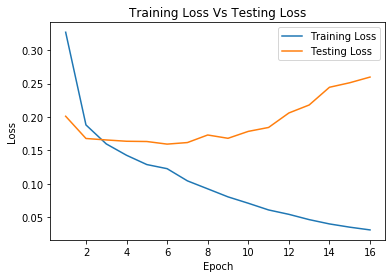

<Figure size 432x288 with 0 Axes>

In [16]:
from matplotlib import pyplot as plt 
plt.plot(range(1,17), training_loss, label='Training Loss')
plt.plot(range(1,17), validation_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title("Training Loss Vs Testing Loss")
plt.legend()
plt.show()
plt.savefig(APR_DIR + 'Loss.png')